## CS5340 Project

### 3.2.3 Mixture Model

Mixture models offer a powerful approach to detecting financial crimes like money laundering by
capturing uncertainty in data. These models assume that the observed data is a mixture of several
underlying probability distributions, each representing a distinct group or behavior. In the context of
financial transactions, this could mean differentiating between legitimate and suspicious activities.

In terms of methodology, mixture models involve two main steps: model fitting and inference. During
model fitting, parameters such as the number of components (groups) and their respective distributions
are estimated from the data using techniques like expectation-maximization (EM)[9, 18 ] algorithm or
Bayesian inference. This step helps identify patterns or clusters within the data, potentially revealing
anomalous behavior associated with money laundering.

Once the model is fitted, inference involves assigning each data point to its most likely component
based on the estimated parameters. Suspicious transactions may then be flagged for investigation
based on their likelihood of belonging to a particular component associated with illicit activity.

### Dataset Download

The dataset(s) used for this project can be downloaded from Kaggle using this [link](https://www.kaggle.com/datasets/ealtman2019/ibm-transactions-for-anti-money-laundering-aml).

It is recommended to save the csv files into a folder named data.

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder, TargetEncoder, LabelEncoder, OneHotEncoder, StandardScaler

In [2]:
%%time
df_train = pd.read_csv('data/HI-Small_Trans_processed_w_original_train.csv')
df_test = pd.read_csv('data/HI-Small_Trans_processed_w_original_test.csv')
df_train.sample(10)

CPU times: total: 9.23 s
Wall time: 9.51 s


,Timestamp,FromAccount,ToAccount,FromBank,ToBank,ReceivingCurrency,PaymentCurrency,PaymentFormat,AmountPaid,AmountReceived,From Bank,To Bank,Account,Account.1,Receiving Currency,Payment Currency,Payment Format,Is Laundering
208516,2022-09-01 00:05:00,136889,136889,12,12,13,13,5,15685991.12,15685991.12,15,15,8038766C0,8038766C0,Yen,Yen,Reinvestment,0
822990,2022-09-01 15:58:00,182195,511252,15,587,14,14,4,106928.81,106928.81,20,9209,802F9C050,8035D3930,Yuan,Yuan,Credit Card,0
2145398,2022-09-04 18:08:00,106294,14464,67,6015,12,12,3,413.26,413.26,1420,111443,80065A5C0,804DE2AA0,US Dollar,US Dollar,Cheque,0
924882,2022-09-01 18:37:00,89813,251731,6243,6672,2,2,2,648312.56,648312.56,134939,235551,80CED1E90,80CF617F0,Brazil Real,Brazil Real,Cash,0
1653728,2022-09-02 18:50:00,78048,19456,651,6028,7,7,4,110726.56,110726.56,13029,112733,804B30190,804D44B10,Rupee,Rupee,Credit Card,0
3033090,2022-09-07 00:13:00,501341,60993,24,640,4,4,4,51.07,51.07,70,12461,1004286A8,8069F9F90,Euro,Euro,Credit Card,0
3869460,2022-09-09 17:29:00,151260,8805,744,8,6,6,3,63972.84,63972.84,16787,10,8062B4870,8073FD610,Ruble,Ruble,Cheque,0
2723892,2022-09-06 05:05:00,208493,108105,42,6329,9,9,4,2984.81,2984.81,217,142836,80FE11DA0,80FFEA700,Shekel,Shekel,Credit Card,0
3852219,2022-09-09 15:56:00,192585,218817,39,850,11,11,0,146.94,146.94,212,22091,807683B90,80849AAC0,UK Pound,UK Pound,ACH,0
3579952,2022-09-08 16:05:00,43529,313899,631,998,12,12,4,14758.09,14758.09,11904,29404,800EC5B80,814723140,US Dollar,US Dollar,Credit Card,0


In [3]:
print("Number of rows in df_train:", len(df_train))
print("Number of rows in df_test:", len(df_test))

Number of rows in df_train: 4009181
Number of rows in df_test: 1069155


#### Understand possible payment formats and currencies

In [4]:
print(df_train['Payment Format'].unique())
print(df_test['Payment Format'].unique())
print(len(df_train[df_train['Payment Format'] == 'Reinvestment']))
print(len(df_test[df_test['Payment Format'] == 'Reinvestment']))

['Reinvestment' 'Cheque' 'Credit Card' 'ACH' 'Cash' 'Wire' 'Bitcoin']
['Cheque' 'Credit Card' 'Cash' 'ACH' 'Wire' 'Bitcoin']
481056
0


In [5]:
recv_currency_train = df_train['Receiving Currency'].unique()
recv_currency_test = df_test['Receiving Currency'].unique()
recv_currency_combined = pd.concat([df_train['Receiving Currency'], df_test['Receiving Currency']]).unique()
print(f"{len(recv_currency_train)}:", recv_currency_train)
print(f"{len(recv_currency_test)}:", recv_currency_test)
print(f"{len(recv_currency_combined)}:", recv_currency_combined)

15: ['US Dollar' 'Bitcoin' 'Euro' 'Australian Dollar' 'Yuan' 'Rupee'
 'Mexican Peso' 'Yen' 'UK Pound' 'Ruble' 'Canadian Dollar' 'Swiss Franc'
 'Brazil Real' 'Saudi Riyal' 'Shekel']
15: ['Yen' 'UK Pound' 'Australian Dollar' 'Shekel' 'Rupee' 'US Dollar' 'Euro'
 'Bitcoin' 'Mexican Peso' 'Saudi Riyal' 'Yuan' 'Brazil Real' 'Ruble'
 'Swiss Franc' 'Canadian Dollar']
15: ['US Dollar' 'Bitcoin' 'Euro' 'Australian Dollar' 'Yuan' 'Rupee'
 'Mexican Peso' 'Yen' 'UK Pound' 'Ruble' 'Canadian Dollar' 'Swiss Franc'
 'Brazil Real' 'Saudi Riyal' 'Shekel']


### Use one currency for all the transactions

so that we are able to observe distributions of the transaction amounts


In [6]:
#
# https://finance.yahoo.com/quote/BTC-USD/history
# https://www.exchangerates.org.uk/US-Dollar-USD-currency-table.html
#
# use the average ex rates over Sep 2022 per Timestamp
#
ex_rates = {
    'Australian Dollar': 1.4958,
    'Bitcoin': 1/20201.19,
    'Brazil Real': 5.2299,
    'Canadian Dollar': 1.3316,
    'Euro': 1.009, 
    'Mexican Peso': 20.055,
    'Ruble': 60.0435,
    'Rupee': 80.2343,
    'Saudi Riyal': 3.7598,
    'Shekel': 3.4489,
    'Swiss Franc': 0.973,
    'UK Pound': 0.836,
    'US Dollar': 1.0,
    'Yen': 143.0069,
    'Yuan': 7.0144,
}

In [7]:
%%time
df_train['AmountReceivedUSD'] = df_train['AmountReceived']
df_train['AmountPaidUSD'] = df_train['AmountPaid']
df_test['AmountReceivedUSD'] = df_test['AmountReceived']
df_test['AmountPaidUSD'] = df_test['AmountPaid']
for currency, rate in ex_rates.items():
    mask = df_train['Receiving Currency'] == currency
    df_train.loc[mask, 'AmountReceivedUSD'] /= rate
    mask = df_train['Payment Currency'] == currency
    df_train.loc[mask, 'AmountPaidUSD'] /= rate
    #
    mask = df_test['Receiving Currency'] == currency
    df_test.loc[mask, 'AmountReceivedUSD'] /= rate
    mask = df_test['Payment Currency'] == currency
    df_test.loc[mask, 'AmountPaidUSD'] /= rate
    #
    print(f"{currency}: {rate}")

Australian Dollar: 1.4958
Bitcoin: 4.950203428609899e-05
Brazil Real: 5.2299
Canadian Dollar: 1.3316
Euro: 1.009
Mexican Peso: 20.055
Ruble: 60.0435
Rupee: 80.2343
Saudi Riyal: 3.7598
Shekel: 3.4489
Swiss Franc: 0.973
UK Pound: 0.836
US Dollar: 1.0
Yen: 143.0069
Yuan: 7.0144
CPU times: total: 6.59 s
Wall time: 6.57 s


In [8]:
pd.set_option('display.float_format', '{:,.3f}'.format)
df_train[['AmountReceived', 'Receiving Currency', 'AmountPaid', 'Payment Currency', 'AmountReceivedUSD', 'AmountPaidUSD']].sample(10)

,AmountReceived,Receiving Currency,AmountPaid,Payment Currency,AmountReceivedUSD,AmountPaidUSD
1101173,"1,145.920",US Dollar,"1,145.920",US Dollar,"1,145.920","1,145.920"
1545390,"4,690.780",US Dollar,"4,690.780",US Dollar,"4,690.780","4,690.780"
1908661,351.440,Euro,351.440,Euro,348.305,348.305
1905759,"259,763.380",Ruble,"259,763.380",Ruble,"4,326.253","4,326.253"
3586276,"1,519.790",Euro,"1,519.790",Euro,"1,506.234","1,506.234"
539836,"73,518.340",US Dollar,"492,396.400",Yuan,"73,518.340","70,197.936"
2937779,"9,942.880",US Dollar,"9,942.880",US Dollar,"9,942.880","9,942.880"
1461660,456.840,Euro,456.840,Euro,452.765,452.765
786216,"782,795.510",Euro,"782,795.510",Euro,"775,813.191","775,813.191"
1071128,471.070,Australian Dollar,471.070,Australian Dollar,314.928,314.928


In [9]:
# df['FromBankAcc'] = df.iloc[:,1].astype(str) + '_' + df.iloc[:,2]
# df['ToBankAcc'] = df.iloc[:,3].astype(str) + '_' + df.iloc[:,4]

In [10]:
# Nominal Encoding
# encode_curr = LabelEncoder().fit(pd.concat([df['Receiving Currency'], df['Payment Currency']], ignore_index=True)) # For all Currency 
# encode_paym_format = LabelEncoder().fit(df['Payment Format']) # Payment Format
# encode_acct = LabelEncoder().fit(pd.concat([df['FromBankAcc'], df['ToBankAcc']], ignore_index=True)) # For all unique Account
# encode_bank = LabelEncoder().fit(pd.concat([df['From Bank'], df['To Bank']], ignore_index=True)) # For all unique Bank codes

In [11]:
%%time

"""
clean_df = pd.DataFrame()

clean_df['Timestamp'] = pd.to_datetime(df['Timestamp'])

clean_df['FromAccount'] = encode_acct.transform(df['FromBankAcc'])
clean_df['ToAccount'] = encode_acct.transform(df['ToBankAcc'])
clean_df['FromBank'] = encode_bank.transform(df['From Bank'])
clean_df['ToBank'] = encode_bank.transform(df['To Bank'])

clean_df['ReceivingCurrency'] = encode_curr.transform(df['Receiving Currency'])
clean_df['PaymentCurrency'] = encode_curr.transform(df['Payment Currency'])
clean_df['PaymentFormat'] = encode_paym_format.transform(df['Payment Format'])
# clean_df['AmountPaid'] = df['Amount Paid']
# clean_df['AmountReceived'] = df['Amount Received']
clean_df['IsLaundering'] = df['Is Laundering']
clean_df['AmountReceivedUSD'] = df['AmountReceivedUSD']
clean_df['AmountPaidUSD'] = df['AmountPaidUSD']

clean_df.head(10)
"""

print()


CPU times: total: 0 ns
Wall time: 0 ns


#### Identify transactions in which AmountReceivedUSD not equal to AmountPaidUSD


In [12]:
df_x = df_train[df_train['AmountReceivedUSD'] != df_train['AmountPaidUSD']]
print(len(df_x))
df_x.sample(5)

68966


,Timestamp,FromAccount,ToAccount,FromBank,ToBank,ReceivingCurrency,PaymentCurrency,PaymentFormat,AmountPaid,AmountReceived,From Bank,To Bank,Account,Account.1,Receiving Currency,Payment Currency,Payment Format,Is Laundering,AmountReceivedUSD,AmountPaidUSD
2818454,2022-09-06 11:01:00,15561,15561,616,616,4,12,0,688.120,587.240,11157,11157,806DF0A10,806DF0A10,Euro,US Dollar,ACH,0,582.002,688.120
3973066,2022-09-10 09:23:00,12347,12347,614,614,4,12,0,842.990,719.410,11107,11107,801B6EE90,801B6EE90,Euro,US Dollar,ACH,0,712.993,842.990
3783027,2022-09-09 09:46:00,44167,44167,632,632,14,12,0,"13,804,424.260","92,456,511.920",11974,11974,800C35760,800C35760,Yuan,US Dollar,ACH,0,"13,180,958.018","13,804,424.260"
3931333,2022-09-09 22:37:00,484856,484856,547,547,11,12,0,"11,815.460","9,147.530",4866,4866,804DC00E0,804DC00E0,UK Pound,US Dollar,ACH,0,"10,942.022","11,815.460"
3796411,2022-09-09 10:42:00,274955,274955,6798,6798,8,4,0,538.280,"2,366.020",246748,246748,811D18A40,811D18A40,Saudi Riyal,Euro,ACH,0,629.294,533.479


In [13]:
df_train.describe()

,FromAccount,ToAccount,FromBank,ToBank,ReceivingCurrency,PaymentCurrency,PaymentFormat,AmountPaid,AmountReceived,From Bank,To Bank,Is Laundering,AmountReceivedUSD,AmountPaidUSD
count,"4,009,181.000","4,009,181.000","4,009,181.000","4,009,181.000","4,009,181.000","4,009,181.000","4,009,181.000","4,009,181.000","4,009,181.000","4,009,181.000","4,009,181.000","4,009,181.000","4,009,181.000","4,009,181.000"
mean,"237,658.867","213,794.525","2,173.811","2,825.882",8.367,8.402,3.067,"4,523,078.947","6,357,212.458","50,844.727","70,343.132",0.001,"359,116.204","356,533.789"
std,"161,157.168","143,944.036","3,780.495","3,108.240",4.125,4.125,1.522,"755,246,400.221","986,954,341.524","85,701.141","85,858.208",0.032,"26,061,733.706","25,564,832.447"
min,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,1.000,0.000,0.000,0.000
25%,"105,290.000","97,226.000",43.000,569.000,4.000,4.000,3.000,179.130,177.590,220.000,"7,042.000",0.000,148.690,148.692
50%,"206,862.000","195,747.000",633.000,867.000,10.000,10.000,3.000,"1,436.220","1,431.770","12,004.000","23,289.000",0.000,876.700,876.858
75%,"350,581.000","291,172.000","2,581.000","6,159.000",12.000,12.000,4.000,"12,755.120","12,815.730","33,884.000","126,876.000",0.000,"5,374.910","5,374.797"
max,"515,087.000","515,087.000","30,469.000","30,464.000",14.000,14.000,6.000,"965,933,305,301.710","965,933,305,301.710","356,303.000","356,294.000",1.000,"28,674,201,827.827","28,674,201,827.827"


### Take a quick look at sample size per class

In [14]:
class_0 = df_train[df_train['Is Laundering'] == 0]
class_1 = df_train[df_train['Is Laundering'] == 1]
print("Class 0:", len(class_0))
print("Class 1:", len(class_1))
class_0 = df_test[df_test['Is Laundering'] == 0]
class_1 = df_test[df_test['Is Laundering'] == 1]
print("Class 0:", len(class_0))
print("Class 1:", len(class_1))

Class 0: 4005109
Class 1: 4072
Class 0: 1068050
Class 1: 1105


#### Box plot of Transaction Amounts by Class

Here `min_samples` is the max sample size of the minority class.

```
min_samples = clean_df.groupby('IsLaundering').size().min()
n_samples = {
    0: min_samples * 100,
    1: min_samples,
}
```

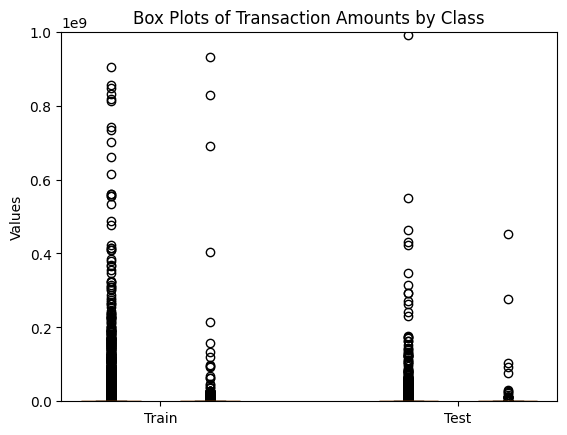

In [15]:
import matplotlib.pyplot as plt
import numpy as np

k = 100

# Find the minimum number of samples among all classes
min_samples_train = df_train.groupby('Is Laundering').size().min()
n_samples_train = {
    0: min_samples_train * k,
    1: min_samples_train,
}

# Find the minimum number of samples among all classes
min_samples_test = df_test.groupby('Is Laundering').size().min()
n_samples_test = {
    0: min_samples_test * k,
    1: min_samples_test,
}

class0_train = df_train[df_train['Is Laundering'] == 0].sample(n=n_samples_train[0])
class1_train = df_train[df_train['Is Laundering'] == 1].sample(n=n_samples_train[1])
class0_test = df_test[df_test['Is Laundering'] == 0].sample(n=n_samples_test[0])
class1_test = df_test[df_test['Is Laundering'] == 1].sample(n=n_samples_test[1])

column = 'AmountReceivedUSD'
data = [class0_train[column], class1_train[column], class0_test[column], class1_test[column]]

fig, ax = plt.subplots()
# Create box plots. Adjust positions to place them side by side.
positions = [1, 2, 4, 5]  # Leaving space between groups
box = ax.boxplot(data, positions=positions, widths=0.6, patch_artist=True)

# Adding different colors for each class within the groups
colors = ['lightblue', 'lightgreen', 'lightblue', 'lightgreen']
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

# Adding labels and titles
ax.set_title('Box Plots of Transaction Amounts by Class')
ax.set_xticks([1.5, 4.5])  # Set ticks in the middle of the groups
ax.set_xticklabels(['Train', 'Test'])
ax.set_ylabel('Values')

# Adding a legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='lightblue', label='Class 0'),
                   Patch(facecolor='lightgreen', label='Class 1')]
# ax.legend(handles=legend_elements, loc='upper right')

# Set y-axis limit
plt.ylim(0, 1e9)  # Adjust the limits as needed

plt.show()

# GMM for binary classification

Initially `min_samples` is the max sample size of the minority class. For final results, we use all samples for training.

```
min_samples = df_train.groupby('IsLaundering').size().min()
n_samples = {
    0: min_samples * 200,
    1: min_samples,
}
```

### Functions for model metrics and CM

In [127]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


def cal_metrics(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    return {
        'accuracy': round(accuracy_score(y_test, y_pred), 6),
        'f1_score_w': round(f1_score(y_test, y_pred, average='weighted'), 6),  # Or use 'macro', 'micro', or None for different averaging methods
        'f1_score_b': round(f1_score(y_test, y_pred, average='binary'), 6),    # Or use 'macro', 'micro', or None for different averaging methods
        'precision': round(precision_score(y_test, y_pred), 6),
        'recall': round(recall_score(y_test, y_pred), 6),
        'tn/fn': tn // fn,
        'fp/tp': fp // tp,
    }


def plot_cm(metrics, y_test, y_pred, outfile=None):
    print("Metrics:", metrics)
    
    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    # cm = confusion_matrix(y_pred, y_test)
    
    # Create a Matplotlib figure
    fig, ax = plt.subplots(figsize=(6, 4.5))
    
    # Plot confusion matrix on the specified axis
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False,
                xticklabels=[0, 1],
                yticklabels=[0, 1], ax=ax)
    for pos in []:
        plt.gca().add_patch(plt.Rectangle(pos, 1, 1, fill=True, color='red', alpha=0.1))  # , edgecolor='red', lw=3))
    plt.ylabel('True labels')
    plt.xlabel('Predicted labels')
    plt.title(f"Confusion Matrix")
    if outfile is not None:
        plt.savefig(outfile)
    plt.show()
    plt.close()

### Attempt \#1: Binary classification with one GMM model (2 components)

In [117]:
import numpy as np
from sklearn.mixture import GaussianMixture
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import classification_report, confusion_matrix

df_train_x = df_train

features = ['AmountPaidUSD', 'AmountReceivedUSD']  # List of features to filter by

# Calculating the 95th percentile for each feature and filtering
for feature in features:
    break
    p99 = np.percentile(df_train[feature], 99)
    df_train_x = df_train_x[df_train_x[feature] <= p99]

columns = ['FromAccount', 'ToAccount',
           # 'FromBank', 'ToBank',
           # 'ReceivingCurrency', 'PaymentCurrency',
           'PaymentFormat',
           # 'AmountPaid', 'AmountReceived',
           'AmountPaidUSD', 'AmountReceivedUSD',
          ]

scaler = StandardScaler()

# sampled_df now contains an equal number of samples from each class
Z_train = df_train_x[columns]
X_train = scaler.set_output(transform='pandas').fit_transform(Z_train)
y_train = df_train_x[['Is Laundering']]
Z_test = df_test[columns]
X_test = scaler.set_output(transform='pandas').transform(Z_test)
y_test = df_test[['Is Laundering']]

# Fit a Gaussian Mixture Model with 2 components
gmm = GaussianMixture(n_components=2, weights_init=[0.001, 0.999], covariance_type='full')  # 'spherical')  # 'diag')  # 'full')
gmm.fit(X_train)

print("gmm.weights_:", gmm.weights_)

# Predict labels using GMM
labels = gmm.predict(X_test)

# Determine which GMM component corresponds to the majority class
majority_class_component = np.argmax(np.bincount(labels))

# Map the GMM labels to match the majority class
adjusted_labels = np.where(labels == majority_class_component, 0, 1)

# Evaluate performance with adjusted labels
print(f"class 0: {len(y_test[y_test['Is Laundering'] == 0])}, class 1: {len(y_test[y_test['Is Laundering'] == 1])}\n")
print(classification_report(y_test, adjusted_labels))
print("Confusion Matrix:")
print(confusion_matrix(y_test, adjusted_labels))

y_pred = adjusted_labels

gmm.weights_: [0.94493504 0.05506496]
class 0: 1068050, class 1: 1105

              precision    recall  f1-score   support

           0       1.00      0.95      0.98   1068050
           1       0.00      0.02      0.00      1105

    accuracy                           0.95   1069155
   macro avg       0.50      0.49      0.49   1069155
weighted avg       1.00      0.95      0.97   1069155

Confusion Matrix:
[[1017166   50884]
 [   1078      27]]


#### Check the misclassifications

Metrics: {'accuracy': 0.951399, 'f1_score': 0.974087, 'precision': 0.00053, 'recall': 0.024434, 'tn/fn': 943, 'fp/tp': 1884}


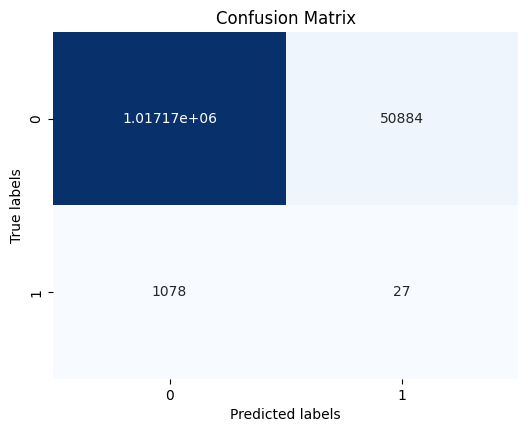

In [118]:
metrics = cal_metrics(y_test, y_pred)
plot_cm(metrics, y_test, y_pred)

### Attempt \#2: Binary classification with one GMM model (2 components)

gmm.weights_: [0.94494208 0.05505792]
majority_component: 0
Metrics: {'accuracy': 0.951402, 'f1_score': 0.974088, 'precision': 0.00053, 'recall': 0.024434, 'tn/fn': 943, 'fp/tp': 1884}


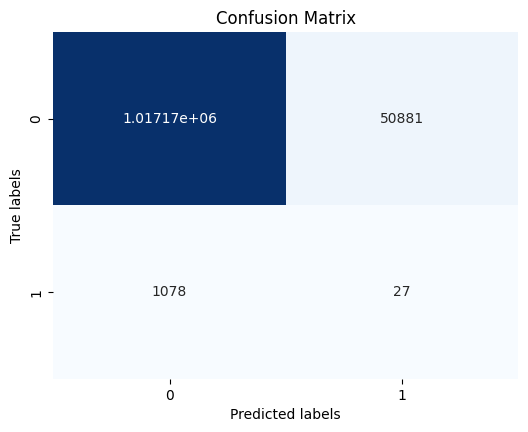

In [119]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

columns = ['FromAccount', 'ToAccount',
           # 'FromBank', 'ToBank',
           # 'ReceivingCurrency', 'PaymentCurrency', 
           'PaymentFormat',
           # 'AmountPaid', 'AmountReceived',
           'AmountPaidUSD', 'AmountReceivedUSD']

scaler = StandardScaler()

# sampled_df now contains an equal number of samples from each class
Z_train = df_train[columns]
X_train = scaler.set_output(transform='pandas').fit_transform(Z_train)
y_train = df_train[['Is Laundering']]
Z_test = df_test[columns]
X_test = scaler.set_output(transform='pandas').transform(Z_test)
y_test = df_test[['Is Laundering']]

# Fit Gaussian Mixture Model
gmm = GaussianMixture(n_components=2, covariance_type='full', random_state=0)
gmm.fit(X_train)

majority_component = np.argmax(gmm.weights_)

# Assign class labels based on mapped GMM components
component_labels = gmm.predict(X_test)

y_pred = np.where(component_labels == majority_component, 0, 1)

print("gmm.weights_:", gmm.weights_)
print("majority_component:", majority_component)

metrics = cal_metrics(y_test, y_pred)
plot_cm(metrics, y_test, y_pred)

### Attempt \#3: Binary classification with two GMM models (each with 1 component to represent 1 class)

In [128]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

df_train_x = df_train

features = ['AmountPaidUSD', 'AmountReceivedUSD']  # List of features to filter by

# Calculating the 95th percentile for each feature and filtering
for feature in features:
    break
    p95 = np.percentile(df_train[feature], 95)
    df_train_x = df_train_x[df_train_x[feature] <= p95]

columns = ['FromAccount', 'ToAccount',
           # 'FromBank', 'ToBank',
           # 'ReceivingCurrency', 'PaymentCurrency',
           'PaymentFormat',
           # 'AmountPaid', 'AmountReceived',
           'AmountPaidUSD', 'AmountReceivedUSD',
          ]

scaler = StandardScaler()

# sampled_df now contains an equal number of samples from each class
Z_train = df_train_x[columns]
X_train = scaler.set_output(transform='pandas').fit_transform(Z_train)
y_train = df_train_x[['Is Laundering']]
Z_test = df_test[columns]
X_test = scaler.set_output(transform='pandas').transform(Z_test)
y_test = df_test[['Is Laundering']]

# Fit Gaussian Mixture Model for each class
gmm_class0 = GaussianMixture(n_components=1, covariance_type='full')  # , random_state=0)
gmm_class1 = GaussianMixture(n_components=1, covariance_type='full')  # , random_state=0)

# Filter data for each class
X_train_class0 = X_train[y_train['Is Laundering'] == 0]
X_train_class1 = X_train[y_train['Is Laundering'] == 1]

# Fit GMMs to each class
gmm_class0.fit(X_train_class0)
gmm_class1.fit(X_train_class1)

likelihoods_class0 = gmm_class0.score_samples(X_test)
likelihoods_class1 = gmm_class1.score_samples(X_test)

prob_class0 = np.exp(likelihoods_class0)
prob_class1 = np.exp(likelihoods_class1)

prob_class0 = np.where(prob_class0 == 0, 1e-10, prob_class0)
prob_class1 = np.where(prob_class1 == 0, 1e-10, prob_class1)

# Normalize probabilities to sum to 1
total_prob = prob_class0 + prob_class1
prob_class0 = prob_class0 / total_prob  # Normalize if needed
prob_class1 = prob_class1 / total_prob  # Normalize if needed

# Predict class with higher likelihood for each row
# y_pred = np.where(likelihoods_class0 > likelihoods_class1, 0, 1)

print(f"class 0: {len(y_test[y_test['Is Laundering'] == 0])}, class 1: {len(y_test[y_test['Is Laundering'] == 1])}\n")

for i in range(10, 100, 5):
    threshold = i / 100
    y_pred = np.where(prob_class1 >= threshold, 1, 0)
    metrics = {'threshold': threshold}
    metrics.update(cal_metrics(y_test, y_pred))
    print(metrics)

class 0: 1068050, class 1: 1105

{'threshold': 0.1, 'accuracy': 0.59899, 'f1_score_w': 0.748134, 'f1_score_b': 0.004851, 'precision': 0.002432, 'recall': 0.945701, 'tn/fn': 10656, 'fp/tp': 410}
{'threshold': 0.15, 'accuracy': 0.627733, 'f1_score_w': 0.770231, 'f1_score_b': 0.005224, 'precision': 0.002619, 'recall': 0.945701, 'tn/fn': 11168, 'fp/tp': 380}
{'threshold': 0.2, 'accuracy': 0.643355, 'f1_score_w': 0.781916, 'f1_score_b': 0.005451, 'precision': 0.002733, 'recall': 0.945701, 'tn/fn': 11446, 'fp/tp': 364}
{'threshold': 0.25, 'accuracy': 0.650745, 'f1_score_w': 0.787366, 'f1_score_b': 0.005566, 'precision': 0.002791, 'recall': 0.945701, 'tn/fn': 11578, 'fp/tp': 357}
{'threshold': 0.3, 'accuracy': 0.659047, 'f1_score_w': 0.793431, 'f1_score_b': 0.005701, 'precision': 0.002859, 'recall': 0.945701, 'tn/fn': 11726, 'fp/tp': 348}
{'threshold': 0.35, 'accuracy': 0.666421, 'f1_score_w': 0.798767, 'f1_score_b': 0.005826, 'precision': 0.002922, 'recall': 0.945701, 'tn/fn': 11857, 'fp/tp'

#### Pick a threshold (say 0.8) as the decision boundary

Threshold: 0.8
              precision    recall  f1-score   support

           0       1.00      0.83      0.91   1068050
           1       0.01      0.86      0.01      1105

    accuracy                           0.83   1069155
   macro avg       0.50      0.84      0.46   1069155
weighted avg       1.00      0.83      0.91   1069155

Confusion Matrix:
[[886359 181691]
 [   159    946]]

Metrics: {'threshold': 0.8, 'accuracy': 0.829912, 'f1_score': 0.906035, 'precision': 0.00518, 'recall': 0.856109, 'tn/fn': 5574, 'fp/tp': 192}


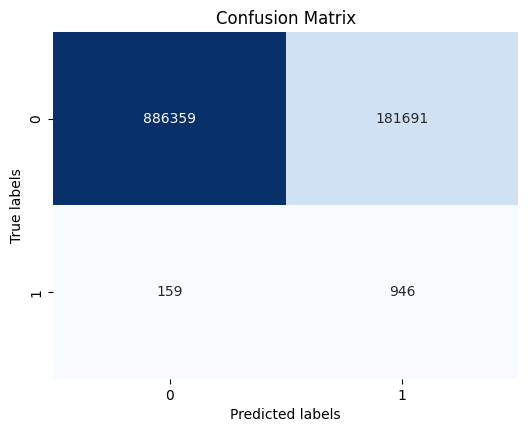

In [126]:
threshold = 0.8
y_pred = np.where(prob_class1 >= threshold, 1, 0)

# Evaluate performance with adjusted labels
print("Threshold:", threshold)  # 0.9 (952) # 0.964 (917)
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print()

metrics = {'threshold': threshold}
metrics.update(cal_metrics(y_test, y_pred))
plot_cm(metrics, y_test, y_pred, outfile="data/gmm3_cm.png")

### Trying ROC-AUC

y_test: 1069155
prob_class1: [0.1175067  0.02150257 0.00024674 0.02150257 0.00024674 0.1175067
 0.02150257 0.00024674 0.1175067  0.1175067 ]


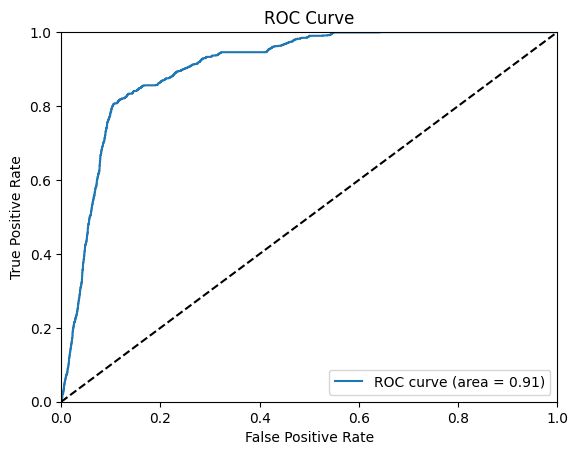

In [123]:
from sklearn.metrics import roc_curve, auc

print("y_test:", len(y_test))
print("prob_class1:", prob_class1[:10])
      
# Calculate TPR, FPR, and AUC
fpr, tpr, thresholds = roc_curve(y_test, prob_class1)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.savefig("data/gmm3_roc-auc.png")
plt.show()

### GMM sample code on synthetic dataset


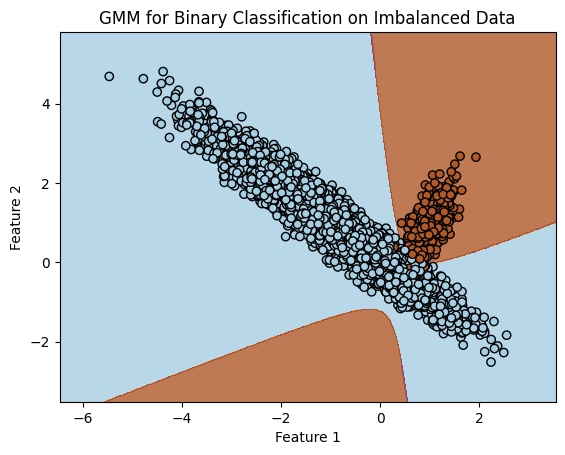

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9500
           1       0.97      0.96      0.96       500

    accuracy                           1.00     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       1.00      1.00      1.00     10000

Confusion Matrix:
[[9486   14]
 [  21  479]]


In [124]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.mixture import GaussianMixture
from sklearn.metrics import classification_report, confusion_matrix

# Generate some synthetic imbalanced data for demonstration
X, y = make_classification(n_samples=10000, n_features=2, n_informative=2,
                            n_redundant=0, n_clusters_per_class=1,
                            weights=[0.95, 0.05], flip_y=0, random_state=42)

# Fit a Gaussian Mixture Model with 2 components
gmm = GaussianMixture(n_components=2)
gmm.fit(X)

# Predict labels using GMM
labels = gmm.predict(X)

# Determine which GMM component corresponds to the majority class
majority_class_component = np.argmax(np.bincount(labels))

# Map the GMM labels to match the majority class
adjusted_labels = np.where(labels == majority_class_component, 0, 1)

# Plot decision boundary
h = .02  # step size in the mesh
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Z = gmm.predict(np.c_[xx.ravel(), yy.ravel()])
Z = np.where(Z == majority_class_component, 0, 1)
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.8)

# Plot the original data points
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired, edgecolors='k')

plt.title('GMM for Binary Classification on Imbalanced Data')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

# Evaluate performance with adjusted labels
print(classification_report(y, adjusted_labels))
print("Confusion Matrix:")
print(confusion_matrix(y, adjusted_labels))
